In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import re
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import numpy as np
import os

The problem ask to identify the spatial distribution of porosities given a certain density. This problem can be modeled as finding conditioned distribution p(x|c) where c is the density of the microstructure and x is the 30e3 vector of the porosities.

In [2]:
path = 'c:/Users/Pietro/Desktop/Porosities/Porosities/'
os.chdir(path)

Start with a standard data analysis before deciding which kind of strategy to apply to the problem


First We build a class to perform standard operations over the samples. Each sample is seen as a 3D distribution that we can plot in 3D. This is useful to understand the evolution of the spatial distribution of porosities. We want to check if some clusters appear increasing the level of porosity density. This imply that porosities are not issued from a random distribution, but there is a hidden criteria behind.

In [3]:
from Lib.Data import PorosityDistribution



We build then 2 functions to extract datas. First one is used to create a dictionary of samples, where each sample is a microstructure. Second one create a dataframe with all the porosities of all the samples. This 2 will be used for different stats

In [4]:
from Lib.Data import extract_microstructures,extract_porosities_points

In [5]:
sample_path = os.getcwd()+'/Job_Assignment_Data/'

In [6]:
extracted_distributions = extract_microstructures(sample_path)
extracted_porosities, density_set = extract_porosities_points(sample_path)

In [7]:
len(extracted_distributions.keys())
train_split = 0.8

train_keys = list(extracted_distributions.keys())[:int(train_split*len(extracted_distributions.keys()))]
test_keys = list(extracted_distributions.keys())[int(train_split*len(extracted_distributions.keys())):]

In [8]:
def get_porosities_per_sample(keys,extracted_distributions):
    porosities = np.zeros((len(keys),extracted_distributions[0].distribution.shape[0]))
    densities = np.zeros((len(keys),1))
    for id,key in enumerate(keys):
        porosities[id,:] = extracted_distributions[key].as_dataframe()['porosity'].values
        densities[id,0] = extracted_distributions[key].density
        
    return porosities,densities

In [9]:
porosities,densities = get_porosities_per_sample(train_keys,extracted_distributions)

In [10]:
porosities.shape

(409, 27000)

In [11]:
from sklearn.decomposition import PCA

pca_comp = 400

pca = PCA(n_components=400)

pca.fit(porosities)

PCA(n_components=400)

In [12]:
pca.explained_variance_ratio_.cumsum()[pca.explained_variance_ratio_.cumsum()<=0.99].shape

(258,)

In [13]:
px.scatter(pca.explained_variance_ratio_)

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_comp = 20

pca = PCA(n_components=pca_comp)
scaler_components = StandardScaler()
scaler_density = StandardScaler()

pc_components_porosities = pca.fit_transform(porosities)
scld_pc_components = scaler_components.fit_transform(pc_components_porosities)

data = pd.DataFrame(scld_pc_components, columns=[i for i in range(pca_comp)])

data['density'] = scaler_density.fit_transform(densities)

X, y =  data['density'].values.reshape(-1,1), data[0].values.reshape(-1,1),

In [15]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,density
0,1.118919,0.799959,0.317715,-0.646963,1.384926,0.184717,-0.073473,0.160450,0.299514,-0.324000,...,0.786008,0.322487,0.715776,1.783746,-0.513057,-1.012564,0.390974,-0.328738,-0.050971,1.121940
1,-0.766825,-0.006476,-0.016532,0.010855,-0.004866,-0.004623,0.046843,-0.004965,0.029940,-0.020896,...,-0.034939,-0.001201,0.022884,-0.061153,0.000239,0.020088,0.037622,0.015150,0.007590,-0.939054
2,2.244718,3.594717,4.738231,1.381115,3.334439,-1.722312,1.056702,0.765578,1.993623,5.133045,...,-0.360806,-3.740349,0.501372,-0.221802,-4.404155,-3.571994,-0.568510,-2.236320,-0.305860,1.570904
3,-0.771769,-0.017806,-0.005160,0.016749,0.001179,0.013294,0.045599,-0.007691,0.040912,-0.015616,...,-0.031646,0.008231,0.011788,-0.055914,0.007601,0.020479,0.057444,0.024327,0.028652,-1.105206
4,-0.252617,0.005744,-0.553955,0.069639,-0.104348,-0.017972,-0.309866,-0.024076,-0.366736,0.138355,...,0.100617,-0.270933,-0.306449,-0.763623,-0.131068,-0.258895,-0.221193,-0.021646,0.301737,0.287644


<Axes: >

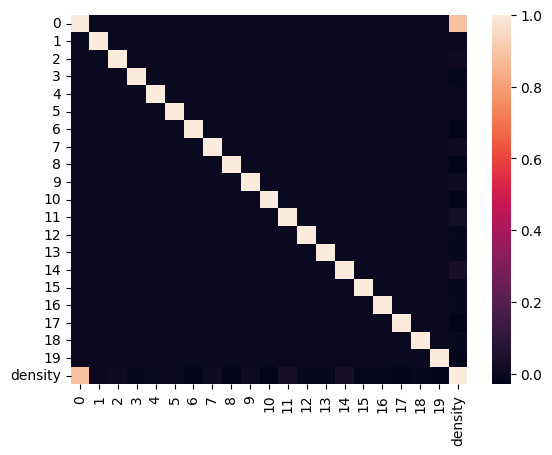

In [16]:
sns.heatmap(data.corr())

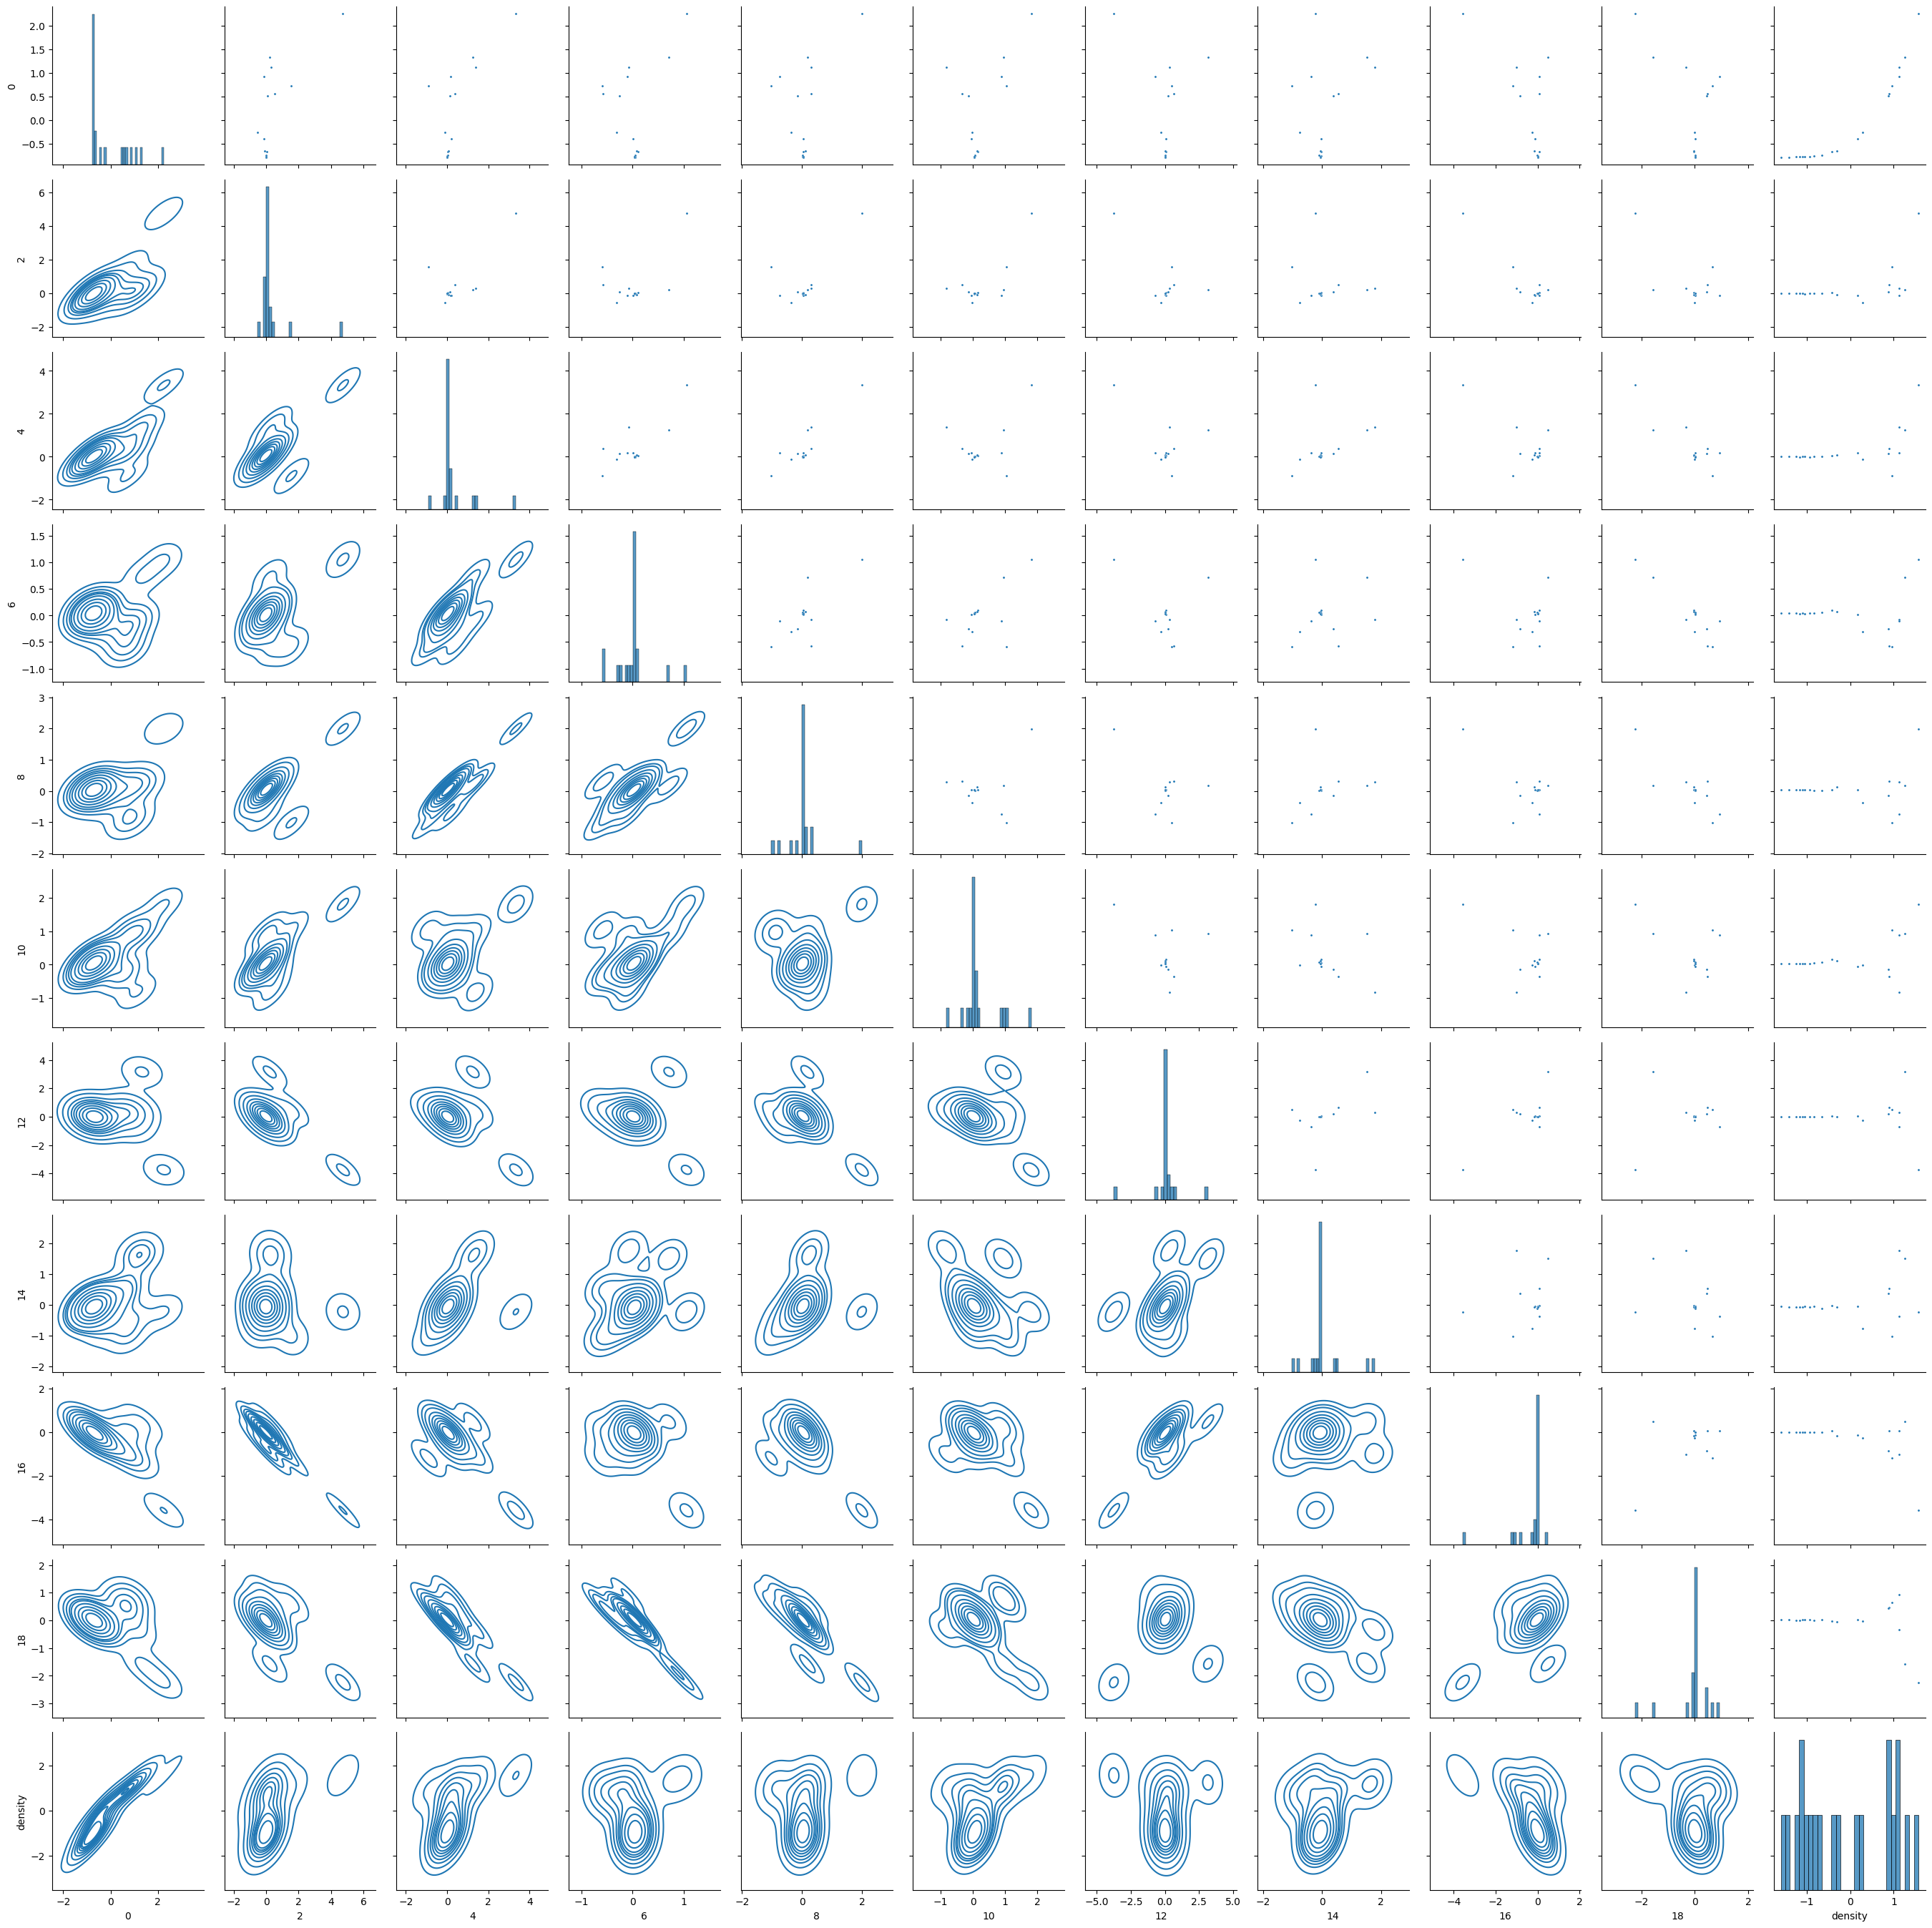

In [17]:

g = sns.PairGrid(data.iloc[:20,::2], diag_sharey=False)
g.map_upper(sns.scatterplot, s=5)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot,bins=30)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


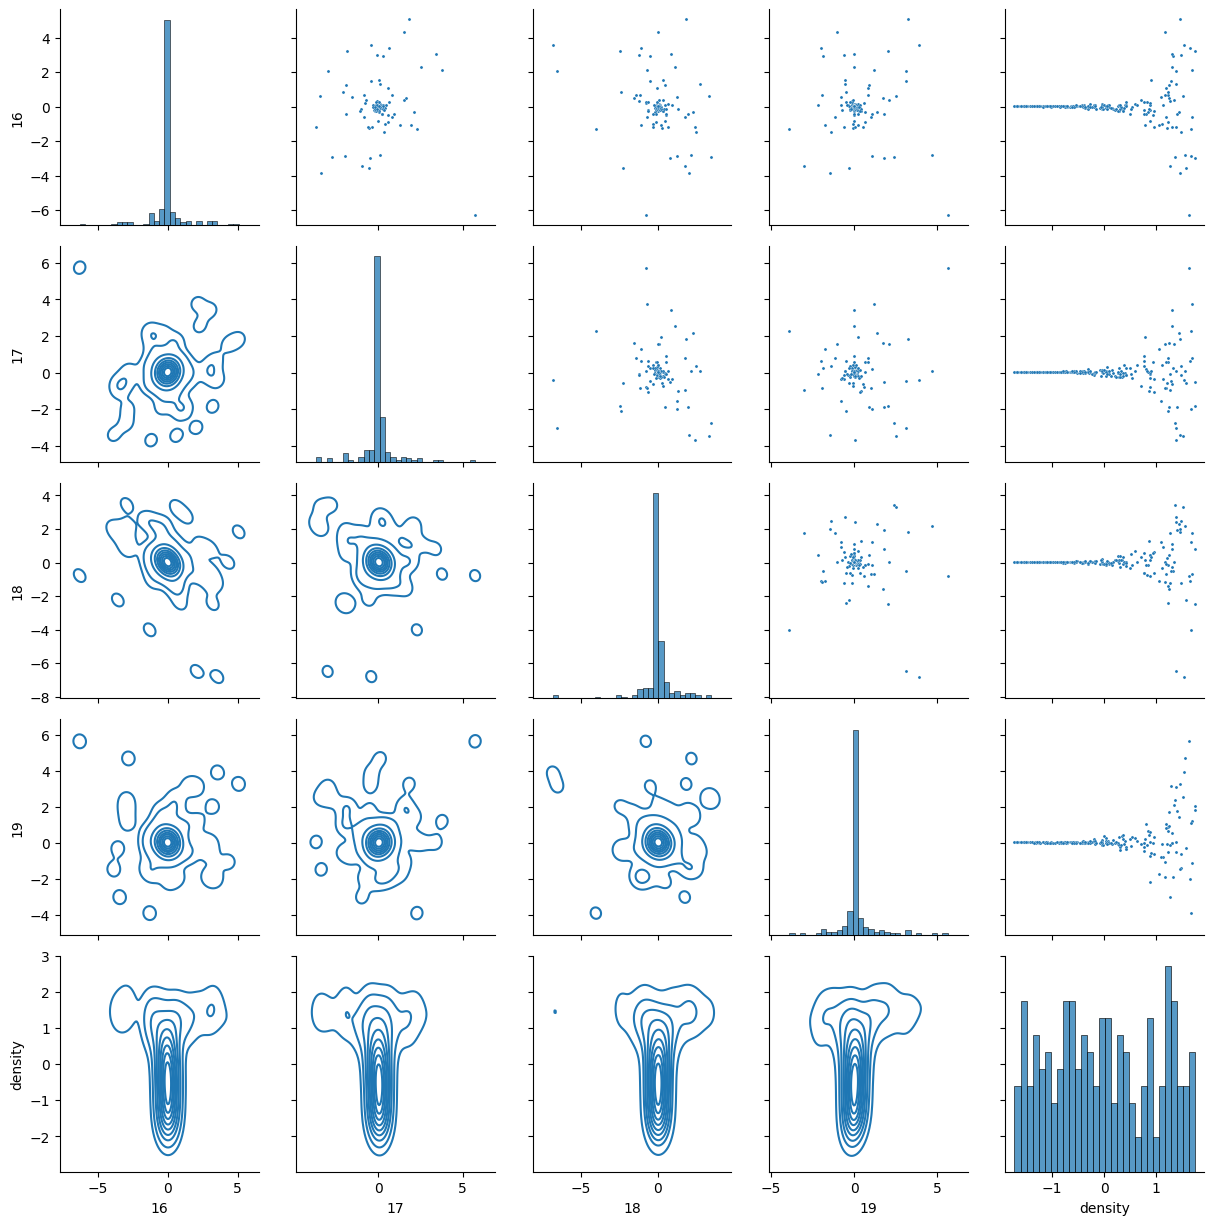

In [ ]:
g = sns.PairGrid(data.iloc[:20,-5::], diag_sharey=False)
g.map_upper(sns.scatterplot, s=5)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot,bins=30)

In [19]:
px.scatter(data,x='density',y=0)

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


poly_feat = PolynomialFeatures(3)

X = data['density'].values.reshape(-1,1)
y = data[0].values.reshape(-1,1)
X_poly = poly_feat.fit_transform(X)

deterministic_regressor = LinearRegression()
deterministic_regressor.fit(X_poly,y)

y_pred = deterministic_regressor.predict(X_poly)

data['0_rec'] = y_pred.reshape(-1)



In [21]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,density,0_rec
0,1.118919,0.799959,0.317715,-0.646963,1.384926,0.184717,-0.073473,0.160450,0.299514,-0.324000,...,0.322487,0.715776,1.783746,-0.513057,-1.012564,0.390974,-0.328738,-0.050971,1.121940,1.022848
1,-0.766825,-0.006476,-0.016532,0.010855,-0.004866,-0.004623,0.046843,-0.004965,0.029940,-0.020896,...,-0.001201,0.022884,-0.061153,0.000239,0.020088,0.037622,0.015150,0.007590,-0.939054,-0.769505
2,2.244718,3.594717,4.738231,1.381115,3.334439,-1.722312,1.056702,0.765578,1.993623,5.133045,...,-3.740349,0.501372,-0.221802,-4.404155,-3.571994,-0.568510,-2.236320,-0.305860,1.570904,2.223068
3,-0.771769,-0.017806,-0.005160,0.016749,0.001179,0.013294,0.045599,-0.007691,0.040912,-0.015616,...,0.008231,0.011788,-0.055914,0.007601,0.020479,0.057444,0.024327,0.028652,-1.105206,-0.774429
4,-0.252617,0.005744,-0.553955,0.069639,-0.104348,-0.017972,-0.309866,-0.024076,-0.366736,0.138355,...,-0.270933,-0.306449,-0.763623,-0.131068,-0.258895,-0.221193,-0.021646,0.301737,0.287644,-0.270579


In [22]:
X.shape

(409, 1)

In [23]:

fig = px.scatter(x=X.reshape(-1), y=y.reshape(-1),
                 opacity=0.5,  # Set opacity for better visualization
                 title="Regression Plot: Actual vs. Predicted First Principal Component")

fig.add_scatter(x=X.reshape(-1), y=y_pred.reshape(-1),
                 opacity=0.5, mode='markers')  # Set opacity for better visualization)

fig.show()

In [24]:
fig = px.scatter(data,x=0, y='0_rec',
                 opacity=0.5,  # Set opacity for better visualization
                 trendline="ols",  # Add trendline using Ordinary Least Squares
                 title="Regression Plot: Actual vs. Predicted Density")

# Add ideal line (y = x)
x_range = np.linspace(data[0].min(), data['0_rec'].max(), 100)
fig.add_scatter(x=x_range, y=x_range, mode='lines',
                line=dict(color='red', dash='dash'),
                name='Ideal Line (y = x)')

fig.update_layout(
    xaxis_title="Actual Density",
    yaxis_title="Predicted Density"
)

fig.show()

In [25]:
stochastic_dimensions = [i for i in range(1,pca_comp)]
stochastic_dimensions.append('density')
stochastic_df = data[stochastic_dimensions].copy()



In [26]:
stochastic_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,density
0,0.799959,0.317715,-0.646963,1.384926,0.184717,-0.073473,0.160450,0.299514,-0.324000,-0.827777,0.786008,0.322487,0.715776,1.783746,-0.513057,-1.012564,0.390974,-0.328738,-0.050971,1.121940
1,-0.006476,-0.016532,0.010855,-0.004866,-0.004623,0.046843,-0.004965,0.029940,-0.020896,0.037225,-0.034939,-0.001201,0.022884,-0.061153,0.000239,0.020088,0.037622,0.015150,0.007590,-0.939054
2,3.594717,4.738231,1.381115,3.334439,-1.722312,1.056702,0.765578,1.993623,5.133045,1.807527,-0.360806,-3.740349,0.501372,-0.221802,-4.404155,-3.571994,-0.568510,-2.236320,-0.305860,1.570904
3,-0.017806,-0.005160,0.016749,0.001179,0.013294,0.045599,-0.007691,0.040912,-0.015616,0.030338,-0.031646,0.008231,0.011788,-0.055914,0.007601,0.020479,0.057444,0.024327,0.028652,-1.105206
4,0.005744,-0.553955,0.069639,-0.104348,-0.017972,-0.309866,-0.024076,-0.366736,0.138355,-0.018310,0.100617,-0.270933,-0.306449,-0.763623,-0.131068,-0.258895,-0.221193,-0.021646,0.301737,0.287644


In [27]:
density_bins=30
stochastic_df['density_bins'] = pd.cut(stochastic_df['density'],bins=density_bins)

means = stochastic_df.groupby(['density_bins']).mean()
stds = stochastic_df.groupby(['density_bins']).std()

C:\Users\Pietro\AppData\Local\Temp\ipykernel_7400\2065903162.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Pietro\AppData\Local\Temp\ipykernel_7400\2065903162.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [28]:
means.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,density
density_bins,,,,,,,,,,,,,,,,,,,,
"(-1.759, -1.639]",-0.007802,-0.013983,0.021446,0.000615,0.006901,0.041765,-0.014652,0.036895,-0.008825,0.035833,-0.037994,0.014439,0.020220,-0.055175,0.014518,0.014428,0.044996,0.017235,0.018258,-1.687419
"(-1.639, -1.522]",-0.007802,-0.013983,0.021446,0.000615,0.006901,0.041765,-0.014652,0.036895,-0.008825,0.035833,-0.037994,0.014439,0.020220,-0.055175,0.014518,0.014428,0.044996,0.017235,0.018258,-1.575381
"(-1.522, -1.405]",-0.007501,-0.013263,0.021524,0.000734,0.006576,0.042006,-0.014974,0.037447,-0.008267,0.036482,-0.038270,0.014810,0.020306,-0.056022,0.014657,0.014347,0.044330,0.017322,0.018775,-1.461594
"(-1.405, -1.288]",-0.005728,-0.012948,0.020412,0.000649,0.005708,0.041470,-0.015444,0.036195,-0.008652,0.035819,-0.037938,0.014545,0.018675,-0.055452,0.016111,0.014041,0.045238,0.018038,0.017415,-1.338798
"(-1.288, -1.171]",-0.008917,-0.014682,0.021240,-0.001450,0.007385,0.041845,-0.015361,0.036409,-0.007988,0.036939,-0.037213,0.012907,0.019701,-0.055178,0.013279,0.012400,0.043525,0.016221,0.017480,-1.230704


In [29]:
dim_means = means.iloc[:,:-1]
dim_stds = stds.iloc[:,:-1]

densities = np.zeros_like(dim_stds.values)
dim_coord = np.zeros_like(densities)

for i in range(densities.shape[0]):
    densities[i,:] = means['density'].iloc[i]
    dim_coord[i,:] = dim_stds.columns.values
    
densities = pd.DataFrame(densities,columns=dim_means.columns,index=dim_means.index)
dim_coord = pd.DataFrame(dim_coord,columns=dim_means.columns,index=dim_means.index)

In [30]:
dim_means.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
density_bins,,,,,,,,,,,,,,,,,,,
"(-1.759, -1.639]",-0.007802,-0.013983,0.021446,0.000615,0.006901,0.041765,-0.014652,0.036895,-0.008825,0.035833,-0.037994,0.014439,0.020220,-0.055175,0.014518,0.014428,0.044996,0.017235,0.018258
"(-1.639, -1.522]",-0.007802,-0.013983,0.021446,0.000615,0.006901,0.041765,-0.014652,0.036895,-0.008825,0.035833,-0.037994,0.014439,0.020220,-0.055175,0.014518,0.014428,0.044996,0.017235,0.018258
"(-1.522, -1.405]",-0.007501,-0.013263,0.021524,0.000734,0.006576,0.042006,-0.014974,0.037447,-0.008267,0.036482,-0.038270,0.014810,0.020306,-0.056022,0.014657,0.014347,0.044330,0.017322,0.018775
"(-1.405, -1.288]",-0.005728,-0.012948,0.020412,0.000649,0.005708,0.041470,-0.015444,0.036195,-0.008652,0.035819,-0.037938,0.014545,0.018675,-0.055452,0.016111,0.014041,0.045238,0.018038,0.017415
"(-1.288, -1.171]",-0.008917,-0.014682,0.021240,-0.001450,0.007385,0.041845,-0.015361,0.036409,-0.007988,0.036939,-0.037213,0.012907,0.019701,-0.055178,0.013279,0.012400,0.043525,0.016221,0.017480


In [31]:
dim_stds.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
density_bins,,,,,,,,,,,,,,,,,,,
"(-1.759, -1.639]",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
"(-1.639, -1.522]",7.845030e-17,5.296512e-17,3.861681e-17,3.047727e-17,8.747940e-17,1.692420e-16,6.398128e-17,3.750856e-16,8.141299e-17,8.617151e-17,2.867050e-16,5.443458e-17,3.895921e-16,2.755439e-16,2.145033e-16,2.025454e-16,2.846356e-16,1.452755e-16,2.731013e-16
"(-1.522, -1.405]",1.228125e-03,1.053564e-03,1.522260e-03,1.369172e-03,1.692710e-03,1.270506e-03,2.093590e-03,1.801812e-03,1.576375e-03,1.757999e-03,1.034969e-03,1.405741e-03,1.254045e-03,1.542545e-03,1.732245e-03,1.167092e-03,1.162334e-03,1.478467e-03,1.824577e-03
"(-1.405, -1.288]",3.175068e-03,2.668895e-03,2.689842e-03,3.448805e-03,2.979368e-03,3.437918e-03,4.000567e-03,2.008705e-03,2.028984e-03,3.485482e-03,1.843529e-03,3.290952e-03,3.870378e-03,2.606953e-03,2.518734e-03,3.355058e-03,2.543285e-03,2.537094e-03,2.422787e-03
"(-1.288, -1.171]",3.578940e-03,3.044945e-03,3.339364e-03,3.460151e-03,2.522417e-03,3.620018e-03,3.816158e-03,2.345579e-03,3.587450e-03,3.259262e-03,3.567662e-03,4.308260e-03,4.022471e-03,3.564306e-03,5.438875e-03,5.506679e-03,5.826564e-03,4.610346e-03,2.413834e-03


In [32]:
densities.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
density_bins,,,,,,,,,,,,,,,,,,,
"(-1.759, -1.639]",-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419,-1.687419
"(-1.639, -1.522]",-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381,-1.575381
"(-1.522, -1.405]",-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594,-1.461594
"(-1.405, -1.288]",-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798,-1.338798
"(-1.288, -1.171]",-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704,-1.230704


In [33]:
dim_coord.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
density_bins,,,,,,,,,,,,,,,,,,,
"(-1.759, -1.639]",1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
"(-1.639, -1.522]",1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
"(-1.522, -1.405]",1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
"(-1.405, -1.288]",1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
"(-1.288, -1.171]",1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0


In [34]:
X = np.zeros((densities.shape[0],densities.shape[1],4))
X[:,:,0] = dim_means.values
X[:,:,1] = dim_stds.values
X[:,:,2] = densities.values
X[:,:,3] = dim_coord.values

gaussian_parameters = pd.DataFrame(X.reshape(densities.shape[0]*densities.shape[1],4),columns=['dim_mean','dim_std','density','dim'])

In [35]:
gaussian_parameters.head()

,dim_mean,dim_std,density,dim
0,-0.007802,0.0,-1.687419,1.0
1,-0.013983,0.0,-1.687419,2.0
2,0.021446,0.0,-1.687419,3.0
3,0.000615,0.0,-1.687419,4.0
4,0.006901,0.0,-1.687419,5.0


In [36]:
px.scatter_3d(gaussian_parameters,x='density',y='dim',z='dim_std',color='dim_std')

In [37]:
px.scatter_3d(gaussian_parameters,x='density',y='dim',z='dim_mean',color='dim_mean')

In [38]:
gaussian_parameters.head()

,dim_mean,dim_std,density,dim
0,-0.007802,0.0,-1.687419,1.0
1,-0.013983,0.0,-1.687419,2.0
2,0.021446,0.0,-1.687419,3.0
3,0.000615,0.0,-1.687419,4.0
4,0.006901,0.0,-1.687419,5.0


In [39]:
X_test = np.random.rand(500,2)

In [40]:
from sklearn.neighbors import KNeighborsRegressor

X = gaussian_parameters[['density','dim']].values
y = gaussian_parameters[['dim_mean','dim_std']].values

statistics_regressor = KNeighborsRegressor(n_neighbors=4)

statistics_regressor.fit(X,y)

y_pred = statistics_regressor.predict(X)

In [41]:
gaussian_parameters['rec_mean'] = y_pred[:,0]
gaussian_parameters['rec_std'] = y_pred[:,1]

In [42]:
px.scatter_3d(gaussian_parameters,x='density',y='dim',z='rec_std',color='rec_std')

In [43]:
px.scatter_3d(gaussian_parameters,x='density',y='dim',z='rec_mean',color='rec_mean')

In [44]:
X_dim_test = np.random.randint(1,pca_comp-1,size=1000)
X_density_test = np.random.rand(1000)
X_test = np.zeros((1000,2))
res = np.zeros((1000,4))

X_test[:,0] = X_density_test
X_test[:,1] = X_dim_test
res[:,0] = X_density_test
res[:,1] = X_dim_test

In [45]:
y_test = statistics_regressor.predict(X_test)
res[:,2:] = y_test

In [46]:
res = pd.DataFrame(res, columns=['density','dim','rec_mean','rec_std'])



In [47]:
px.scatter_3d(res,x='density',y='dim',z='rec_mean',color='rec_mean')

In [48]:
px.scatter_3d(res,x='density',y='dim',z='rec_std',color='rec_std')

In [49]:
import numpy as np

def generate(samples, density,deterministic=True):

    components = np.zeros((samples,pca_comp))
    sc_density = scaler_density.transform(np.array([[density]]))

    principal = deterministic_regressor.predict(poly_feat.transform(sc_density))
    components[:,0]=principal
    sc_density = sc_density[0,0]

    for dimension in range(1,pca_comp):
        
        X = np.array([[sc_density,dimension]])
        
        statistics = statistics_regressor.predict(X)
        #print(statistics,dimension)
        mean_dimension = statistics[0,0]
        std_dimensions = statistics[0,1]
        
        components[:,dimension] = np.random.normal(loc = mean_dimension, scale = std_dimensions,size=samples)
        if deterministic:
            components[:,dimension] = mean_dimension
        
    porosities = pca.inverse_transform(scaler_components.inverse_transform(components))

    #print(porosities.shape)
        
    return porosities
    

In [50]:
porosities = generate(100,0.2)

In [51]:
porosities

array([[ 0.002168  , -0.00228184, -0.00655789, ..., -0.00544538,
         0.0014087 , -0.00089681],
       [ 0.002168  , -0.00228184, -0.00655789, ..., -0.00544538,
         0.0014087 , -0.00089681],
       [ 0.002168  , -0.00228184, -0.00655789, ..., -0.00544538,
         0.0014087 , -0.00089681],
       ...,
       [ 0.002168  , -0.00228184, -0.00655789, ..., -0.00544538,
         0.0014087 , -0.00089681],
       [ 0.002168  , -0.00228184, -0.00655789, ..., -0.00544538,
         0.0014087 , -0.00089681],
       [ 0.002168  , -0.00228184, -0.00655789, ..., -0.00544538,
         0.0014087 , -0.00089681]], shape=(100, 27000))

In [52]:
density = 0.8
porosities = generate(100,density)


template = np.load(os.path.join(sample_path, 'distribution_000_0.821.npy'))

array_data = template
array_data[:,3] = porosities[0,:]
# Store in the dictionary
sample = PorosityDistribution(array_data, density=density)
sample.plot_porosity_distribution(porosity=0.5)